In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import mean_squared_error

## Bitcoin

In [210]:
data = pd.read_csv('data/BTC.csv')

In [211]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3.048000e+03
mean,12895.490498,13219.802130,12534.169159,12900.698520,12900.698520,1.637023e+10
std,16144.364215,16557.227918,15667.046234,16139.933117,16139.933117,1.992438e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,682.358993,695.159989,669.351745,685.084763,685.084763,1.034188e+08
50%,7172.590088,7328.993897,6972.497070,7182.919678,7182.919678,7.636265e+09
75%,16919.418457,17201.264649,16655.772461,16940.592773,16940.592773,2.792719e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


[Text(0, 0, '2014-09-17'),
 Text(200, 0, '2015-04-05'),
 Text(400, 0, '2015-10-22'),
 Text(600, 0, '2016-05-09'),
 Text(800, 0, '2016-11-25'),
 Text(1000, 0, '2017-06-13'),
 Text(1200, 0, '2017-12-30'),
 Text(1400, 0, '2018-07-18'),
 Text(1600, 0, '2019-02-03'),
 Text(1800, 0, '2019-08-22'),
 Text(2000, 0, '2020-03-09'),
 Text(2200, 0, '2020-09-25'),
 Text(2400, 0, '2021-04-13'),
 Text(2600, 0, '2021-10-30'),
 Text(2800, 0, '2022-05-18'),
 Text(3000, 0, '2022-12-04')]

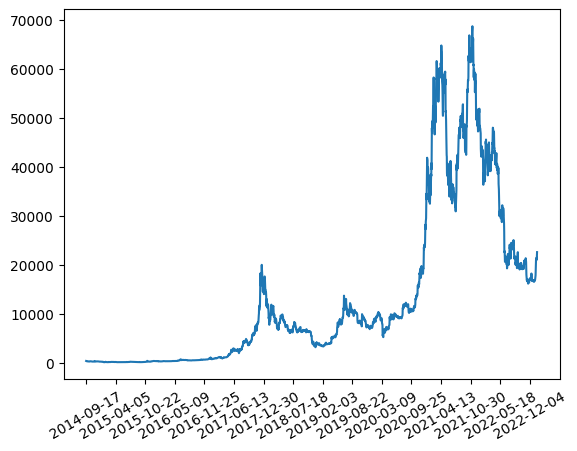

In [212]:
g = sns.lineplot(x = np.linspace(1,3049,3049), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,3049,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

In [213]:
data_high = data["High"].to_numpy()
data_high = data_high[np.logical_not(np.isnan(data_high))]
data_high.shape

(3048,)

In [214]:
scaler = MinMaxScaler(feature_range = (0, 1))

data_normalized = scaler.fit_transform(data_high.reshape((-1, 1)))
data_normalized = np.reshape(data_normalized, (3048,))

In [215]:
def create_dataset(dataset, time_steps=1):
    data_x, data_y = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        data_x.append(a)
        data_y.append(dataset[i + time_steps])
    return np.array(data_x), np.array(data_y)

In [216]:
time_steps = 1

X, y = create_dataset(data_normalized, time_steps)

In [217]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0: train_size, :], X[train_size: len(X), :]
y_train, y_test = y[0: train_size], y[train_size: len(y)]

In [218]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape

(2436, 1, 1)

In [219]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(1, time_steps), dropout=0.2))

model.add(layers.Dense(1))

In [220]:
loss = 'mean_squared_error'

opt = 'adam'

metrics = ['mean_squared_error']

filepath = "models/bitcoin_model.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='mean_squared_error', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

model.compile(loss = loss, 
              optimizer = opt,
              metrics = metrics)

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 64)                16896     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [221]:
batchsize = 32

epochs =  100

# Fit model
history = model.fit(X_train, 
                    y_train, 
                    epochs = epochs, 
                    batch_size = batchsize,
                    validation_split = 0.2,
                    shuffle=False,
                    callbacks = callbacks_list)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.0018        
Epoch 1: mean_squared_error improved from inf to 0.00178, saving model to models\bitcoin_model.hdf5
61/61 [==============================] - 3s 10ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0996 - val_mean_squared_error: 0.0996
Epoch 2/100
58/61 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2: mean_squared_error did not improve from 0.00178
61/61 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0940 - val_mean_squared_error: 0.0940
Epoch 3/100
58/61 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 3: mean_squared_error did not improve from 0.00178
61/61 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0779 - val_mean_squared_error: 0.0779
Epoch 4/100
56/

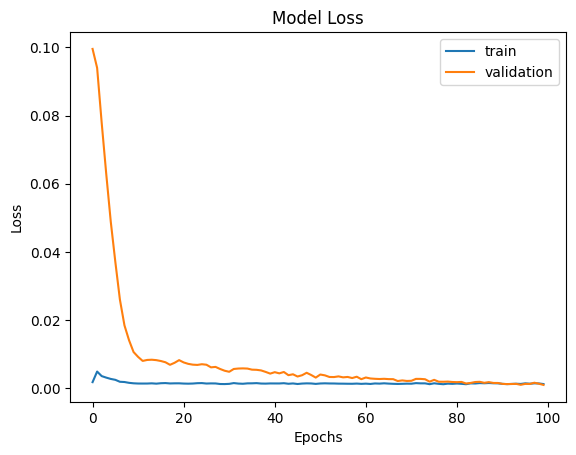

In [222]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

77/77 [==============================] - 0s 971us/step
Test Score: 3024.54 RMSE


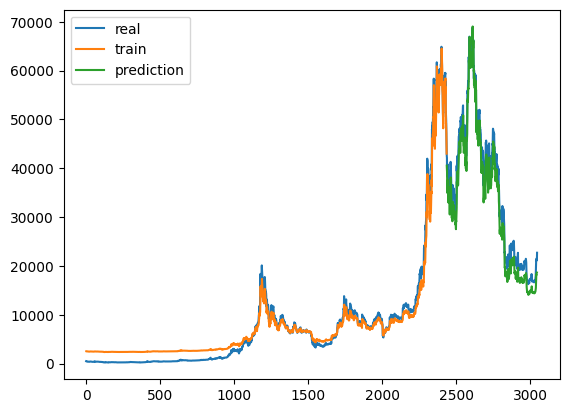

In [223]:
dataset = scaler.fit_transform(data_high.reshape((-1, 1)))

test_predict = model.predict(X_test)
train_predict = model.predict(X_train)

train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

train_plot = np.empty_like(dataset)
train_plot[:, :] = np.nan
train_plot[time_steps:len(train_predict)+time_steps, :] = train_predict

test_plot = np.empty_like(dataset)
test_plot[:] = np.nan
test_plot[len(train_predict)+time_steps:len(dataset)-1] = test_predict

plt.plot(scaler.inverse_transform(data_normalized.reshape(-1, 1)))
plt.plot(train_plot)
plt.plot(test_plot)
plt.legend(['real', 'train', 'prediction'])
plt.show()

## Ethereum

In [ ]:
data_eth = pd.read_csv('data/ETH.csv')